<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/TFLANN_with_JAYA-trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [ ]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [ ]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x) 
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [ ]:
train_x = data3.iloc[:int(0.85*len(data2)), :9]
train_y = data3.iloc[:int(0.85*len(data2)), 9:10]
test_x = data3.iloc[int(0.85*len(data2)):, :9]
test_y = data3.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(663, 9)
(663, 1)
(108, 9)
(108, 1)


In [ ]:
class TFLANN():
  def __init__(self, W, learn_rate):
    self.learning_rate = learn_rate
    self.weight_matrix = W
  
  def func_x(self, x):
    const_x = np.ones((len(x), 1))
    orginal_x = x
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    functioned_x = np.hstack((x, sinned_x, cossed_x, const_x))
    return functioned_x

  def tanh_derivative(self, x):
    return 1.0 - (np.tanh(x) ** 2)

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return np.tanh(np.dot(funced_x, self.weight_matrix))

  def train(self, train_x, train_y, epochs):
    self.me_curve = np.array([])
    for iteration in range(epochs):
      y = self.forward_propagation(train_x)

      error = train_y - y

      adjustment=np.dot(self.learning_rate*self.func_x(train_x).T,error*self.tanh_derivative(y))

      self.weight_matrix += adjustment
      self.me_curve = np.append(self.me_curve, np.mean(error[9]**2))

In [50]:
find_mse = lambda x , y: np.mean((x - y) ** 2)

class JAYATFLANN():
  def __init__(self, p_size, lr1):
    self.p_size = p_size
    self.data = []
    self.lr1 = lr1
    self.error_curve = []

    print("Intialise population")
    for i in range(p_size):
      print("i = " + str(i))
      d = {}
      d['W'] = 2*np.random.random((9*3 + 1, 1)) - 1
      model = TFLANN(d['W'], 0.00035)
      model.train(train_x, train_y, 10000)
      d['W'] = model.weight_matrix
      d['mse'] = find_mse(model.forward_propagation(train_x), train_y)
      self.data.append(d)

    # print(sum([v['mse'][9] for v in self.data]))
    # print([v['mse'][9] for v in self.data])

    self.update_best_and_worst()

  def update_best_and_worst(self):
    self.best = 0
    self.worst = 0
    mean_mse = 0
    for i in range(self.p_size):
      if self.data[self.best]['mse'][9] > self.data[i]['mse'][9]:
        self.best = i
      if self.data[self.worst]['mse'][9] < self.data[i]['mse'][9]:
        self.worst = i
      mean_mse += self.data[i]['mse'][9]
    mean_mse /= self.p_size

    self.error_curve += [[self.data[self.best]['mse'][9], mean_mse, self.data[self.worst]['mse'][9]]]

  def next_gen(self):
    for i in range(self.p_size):
      t =  self.data[i]['W']
      t += self.lr1 * (2*np.random.random((9*3 + 1, 1)) - 1)* (self.data[self.best]['W'] - self.data[i]['W'])
      # t -= self.lr1 * (2*np.random.random((9*3 + 1, 1)) - 1)* (self.data[self.worst]['W'] - self.data[i]['W'])
      model = TFLANN(t, 0.00035)
      mse = find_mse(model.forward_propagation(train_x), train_y)
      if mse[9] < self.data[i]['mse'][9]:
        self.data[i] = {'W': t, 'mse':mse}

    self.update_best_and_worst()

  def optimise(self, gen):
    for i in range(gen):
      print("gen " + str(i))
      self.next_gen()
      # print(str(self.data[self.best]['mse'][9]) + "\t" + str(self.data[self.worst]['mse'][9]))
      if self.data[self.best]['mse'][9] == self.data[self.worst]['mse'][9]:
        break
    b = self.data[self.best]['mse'][9]
    w = self.data[self.worst]['mse'][9]
    print(str(self.lr1) + "\t" + str(b) + "\t" + str(w) + "\t" + str(w - b))

In [51]:
optimiser = JAYATFLANN(50, 2)
optimiser.optimise(1000)
optimiser.data[optimiser.best]['mse'][9]

Intialise population
i = 0


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
gen 0
gen 1
gen 2
gen 3
gen 4
gen 5
gen 6
gen 7
gen 8
gen 9
gen 10
gen 11
gen 12
gen 13
gen 14
gen 15
gen 16
gen 17
gen 18
gen 19
gen 20
gen 21
gen 22
gen 23
gen 24
gen 25
gen 26
gen 27
gen 28
gen 29
gen 30
gen 31
gen 32
gen 33
gen 34
gen 35
gen 36
gen 37
gen 38
gen 39
gen 40
gen 41
gen 42
gen 43
gen 44
gen 45
gen 46
gen 47
gen 48
gen 49
gen 50
gen 51
gen 52
gen 53
gen 54
gen 55
gen 56
gen 57
gen 58
gen 59
gen 60
gen 61
gen 62
gen 63
gen 64
gen 65
gen 66
gen 67
gen 68
gen 69
gen 70
gen 71
gen 72
gen 73
gen 74
gen 75
gen 76
gen 77
gen 78
gen 79
gen 80
gen 81
gen 82
gen 83
gen 84
gen 85
gen 86
gen 87
gen 88
gen 89
gen 90
gen 91
gen 92
gen 93
gen 94
gen 95
gen 

0.0005682442557904148

In [40]:
error_curve = np.array(optimiser.error_curve)
error_curve

array([[0.00160667, 0.00280612, 0.0044777 ],
       [0.00160667, 0.00280612, 0.0044777 ],
       [0.00160667, 0.00280612, 0.0044777 ],
       ...,
       [0.00097818, 0.00104082, 0.00127296],
       [0.00097818, 0.00104082, 0.00127296],
       [0.00097818, 0.00104082, 0.00127296]])

In [52]:
error_curve = np.array(optimiser.error_curve)
error_curve

array([[0.00060633, 0.00075225, 0.00093855],
       [0.00060633, 0.00075225, 0.00093855],
       [0.00060633, 0.00075225, 0.00093855],
       ...,
       [0.00056824, 0.00057611, 0.00058952],
       [0.00056824, 0.00057611, 0.00058952],
       [0.00056824, 0.0005761 , 0.00058952]])

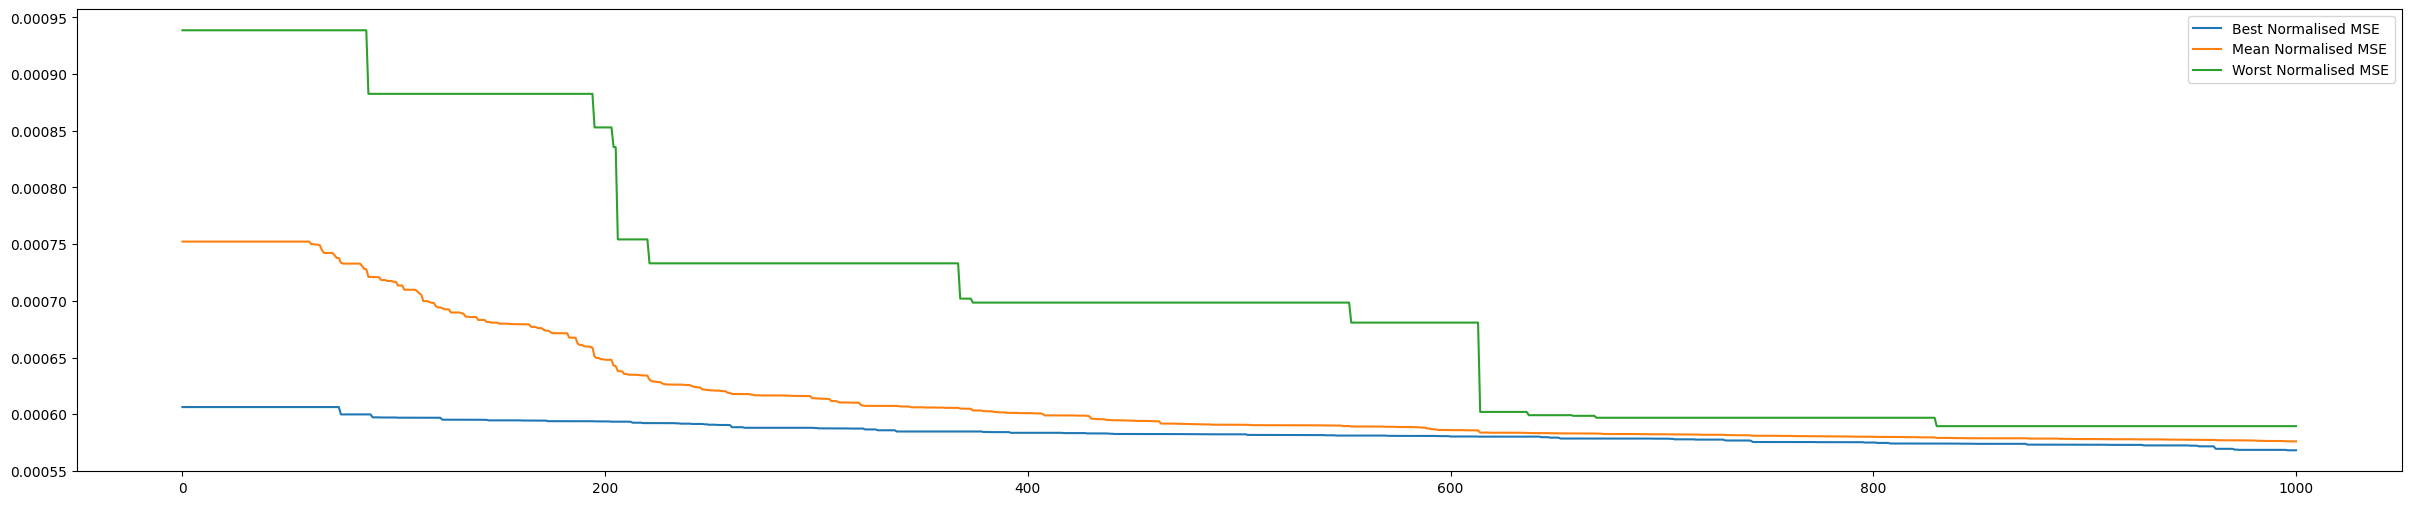

In [53]:
plt.figure(figsize=(30, 6))
plt.plot(error_curve[:, 0])
plt.plot(error_curve[:, 1])
plt.plot(error_curve[:, 2])
plt.legend(["Best Normalised MSE", "Mean Normalised MSE", "Worst Normalised MSE"])
plt.show()

In [54]:
model = TFLANN(optimiser.data[optimiser.best]['W'], 0.00035)
preds = model.forward_propagation(test_x)
print(preds.shape)

(108, 1)


In [55]:
preds[:, 0]

array([0.18760003, 0.19881406, 0.19699787, 0.20333807, 0.20245463,
       0.19184376, 0.18590815, 0.19123761, 0.18914454, 0.18846545,
       0.18293316, 0.20076   , 0.20176959, 0.20852033, 0.21612177,
       0.21810354, 0.21597291, 0.21360943, 0.22892079, 0.23780882,
       0.24285667, 0.28779465, 0.29420971, 0.32851628, 0.35070486,
       0.3477806 , 0.3618897 , 0.29100215, 0.30054241, 0.34480148,
       0.34230719, 0.34377648, 0.31364452, 0.32619226, 0.36690751,
       0.34440072, 0.37778324, 0.38758119, 0.39704274, 0.386468  ,
       0.35173786, 0.3803132 , 0.36989648, 0.37815311, 0.34775144,
       0.31608511, 0.32122594, 0.33013675, 0.34466317, 0.33042904,
       0.31618683, 0.35042619, 0.34188996, 0.35637549, 0.3597845 ,
       0.37307807, 0.4066859 , 0.40621835, 0.42391892, 0.41001607,
       0.4243661 , 0.42947475, 0.47288021, 0.51068746, 0.51592137,
       0.52837444, 0.57404433, 0.65133894, 0.52947814, 0.61005078,
       0.53664303, 0.55276147, 0.43331875, 0.51131192, 0.57895

In [70]:
E = (test_y.reset_index()[9] - preds[:, 0])
print("mse = " + str(np.mean(E**2)))
print("rmse = " + str(np.sqrt(np.mean(E**2))))
print("mae = " + str(np.mean(abs(E))))
print("mape = " + str(np.mean(abs(E)/test_y.reset_index()[9])))

mse = 0.000923692116078778
rmse = 0.03039230356650805
mae = 0.021730402171177658
mape = 0.052887703825000645


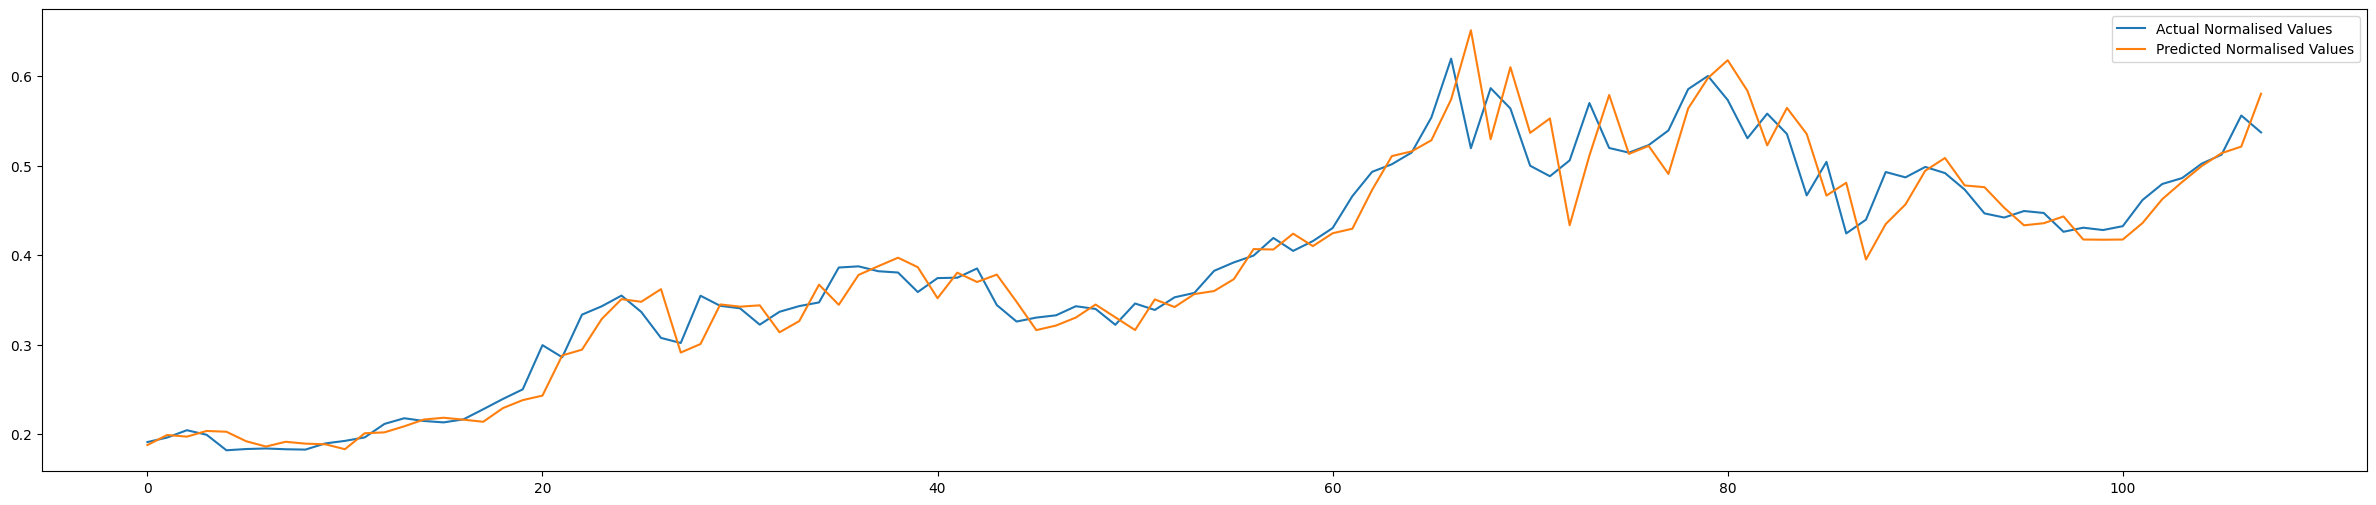

In [56]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.legend(["Actual Normalised Values", "Predicted Normalised Values"])
plt.show()

In [57]:
d1 = (data1max - data1min + 2)[0]
print(type(d1))
denormalized_preds = (preds*d1)[:,0]
# print(denormalized_preds)
denormalized_preds += (data1min + 1)[0]
# print(denormalized_preds)
preds1 = pd.DataFrame(denormalized_preds)
preds1['DATE'] = data1.index[-1*len(preds1):]
preds1 = preds1.set_index('DATE')
print(preds1)

<class 'numpy.float64'>
                       0
DATE                    
2019-04-22   5240.847739
2019-04-23   5439.787077
2019-04-24   5407.567595
2019-04-25   5520.044165
2019-04-26   5504.371618
...                  ...
2019-08-03  10456.693558
2019-08-04  10775.509378
2019-08-05  11029.759395
2019-08-06  11160.471145
2019-08-07  12208.499826

[108 rows x 1 columns]


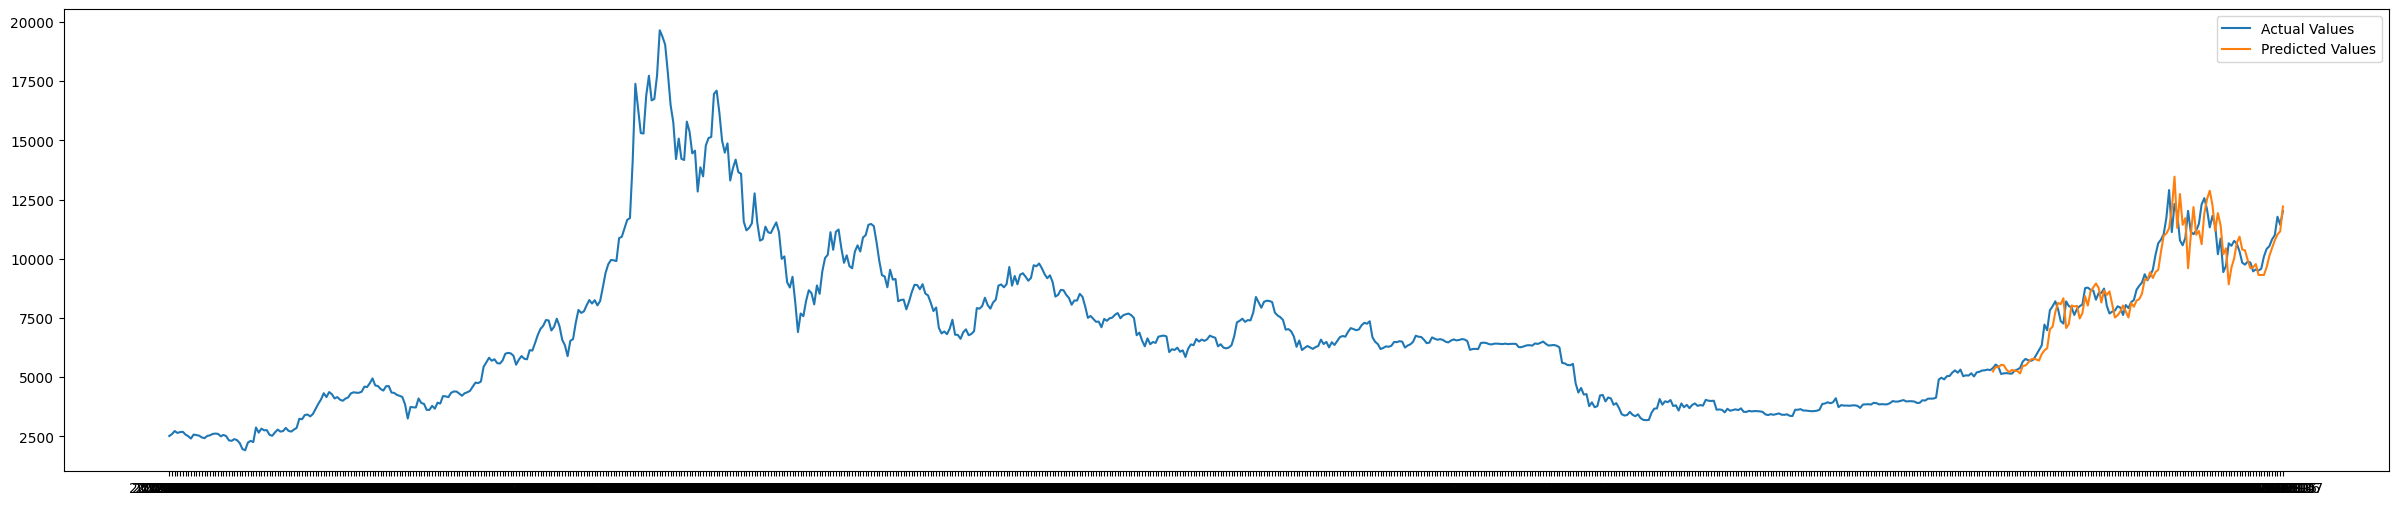

In [58]:
plt.figure(figsize=(30, 6))
plt.plot(data1)
plt.plot(preds1)
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [59]:
mse = np.mean((np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))**2)
print("mse  "+ str(mse))
print("rmse "+ str(np.sqrt(mse)))

mse  476798.40138561715
rmse 690.5059024987528
